# Overview

In [7]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir
plt.rcParams.update({'font.size':15})

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=4)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://10.148.1.35:57178' processes=0 threads=0, memory=0 B>

In [4]:
DS={}
for l in labels: 
    #IMPORT DATA
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    DS[l]=ds_data.persist()
    print(l)

gps_SASSA_SARAL_2018
gps_SASSA_Sentinel_2018
argos_SASSA_SARAL_2018
argos_SASSA_Sentinel_2018
argos_SASSA_Sentinel_2016
argos_PEACHI_Sentinel_2018
gps_PEACHI_Sentinel_2018


## Repartition

In [5]:
dl = 5
lon, lat = np.arange(-180, 180+dl, dl), np.arange(-90,90+dl,dl)
bins_lonlat =[lon,lat]

repart_list = []
for key in DS:
    repartition = diag.coloc_repartition(DS[key], bins=bins_lonlat)
    repart_list.append(repartition)
ds_repart = xr.concat(repart_list, dim = pd.Index(name='drifter_sat_year', data=labels))

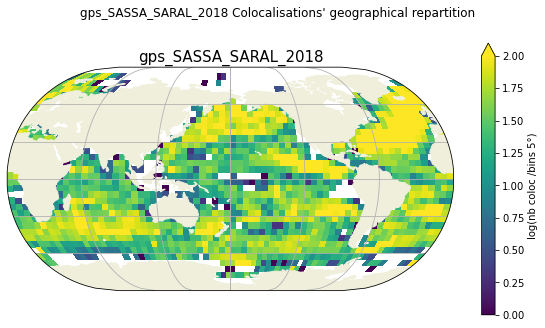

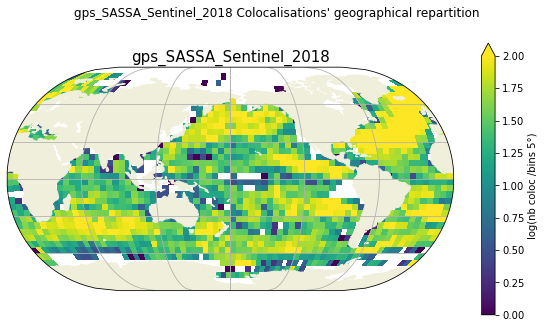

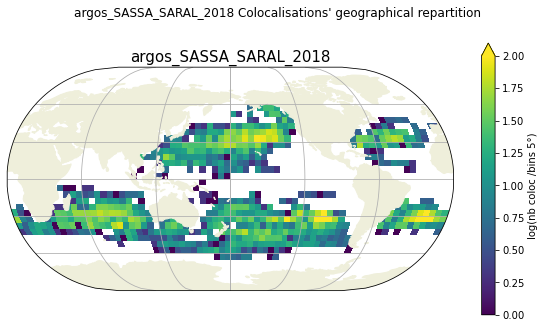

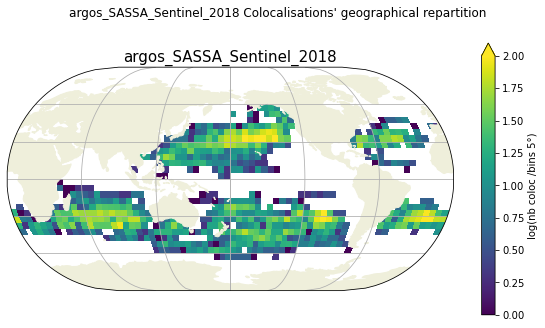

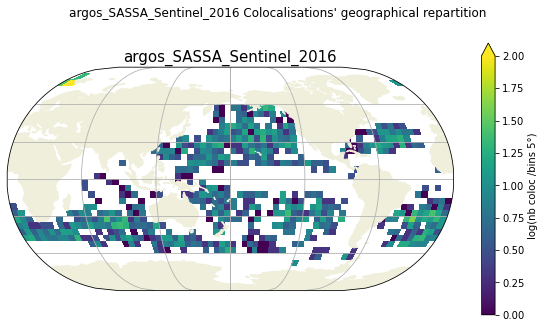

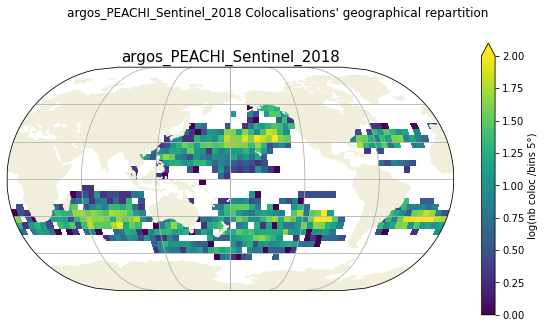

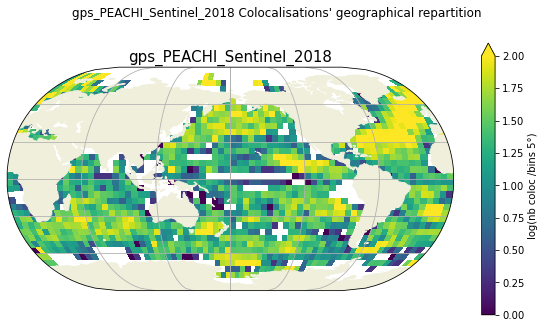

In [52]:
dl = 5
lon, lat = np.arange(-180, 180, dl), np.arange(-90,90,dl)
bins_lonlat =[lon,lat]

repart_list = []
for key in DS:

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    np.log10(ds_repart.sel(drifter_sat_year=key).rename('log(nb coloc /bins '+str(dl) +'°)')).plot(x="lon_bin", y="lat_bin", ax=ax, vmax=2,transform=ccrs.PlateCarree())
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    ax.set_title(key,fontsize=15)
    gl = ax.gridlines()
    fig.suptitle(f"{key} Colocalisations' geographical repartition")

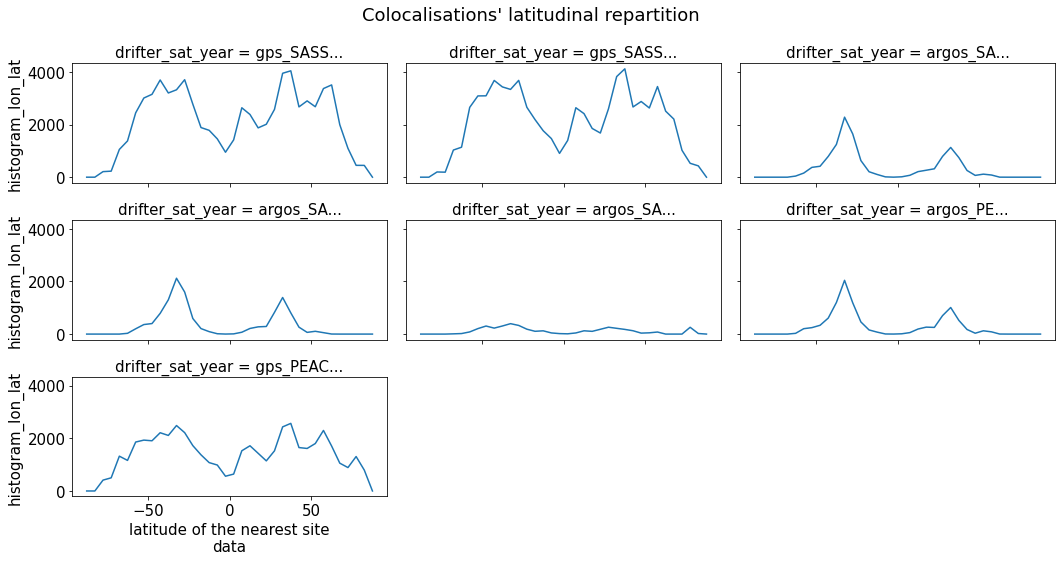

In [9]:
fg = ds_repart.sum("lon_bin").plot(col='drifter_sat_year', col_wrap=3, figsize=(15,8))
fg.fig.suptitle("Colocalisations' latitudinal repartition")
fg.fig.tight_layout()

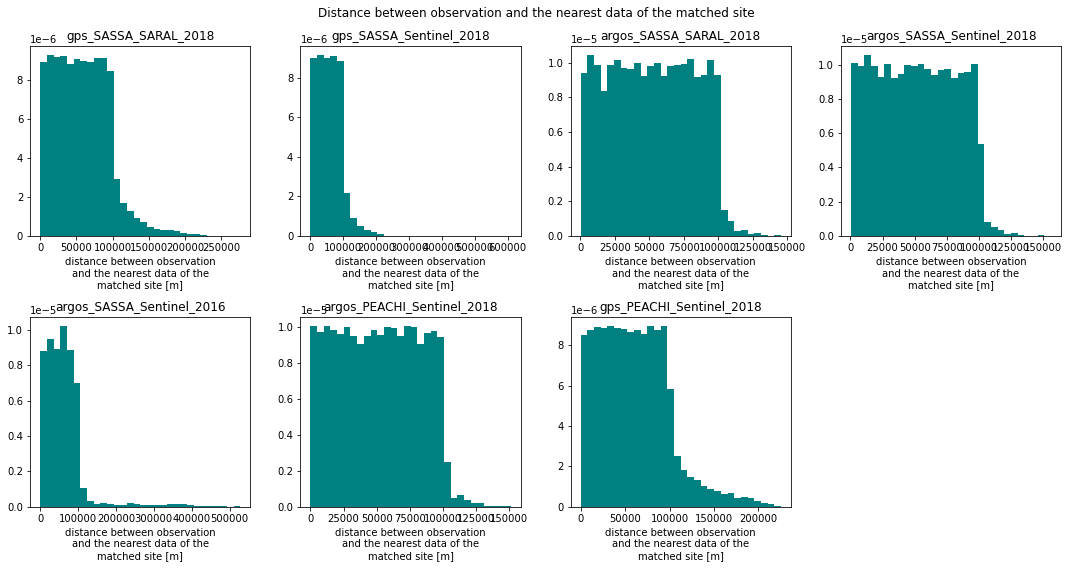

In [54]:
fig = plt.figure(figsize=(15,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    DS[key]["alti___distance"].plot.hist(bins=30, ax=ax,density=True, color='teal')
    ax.set_title(key)
    j+=1

fig.suptitle("Distance between observation and the nearest data of the matched site")
fig.tight_layout()

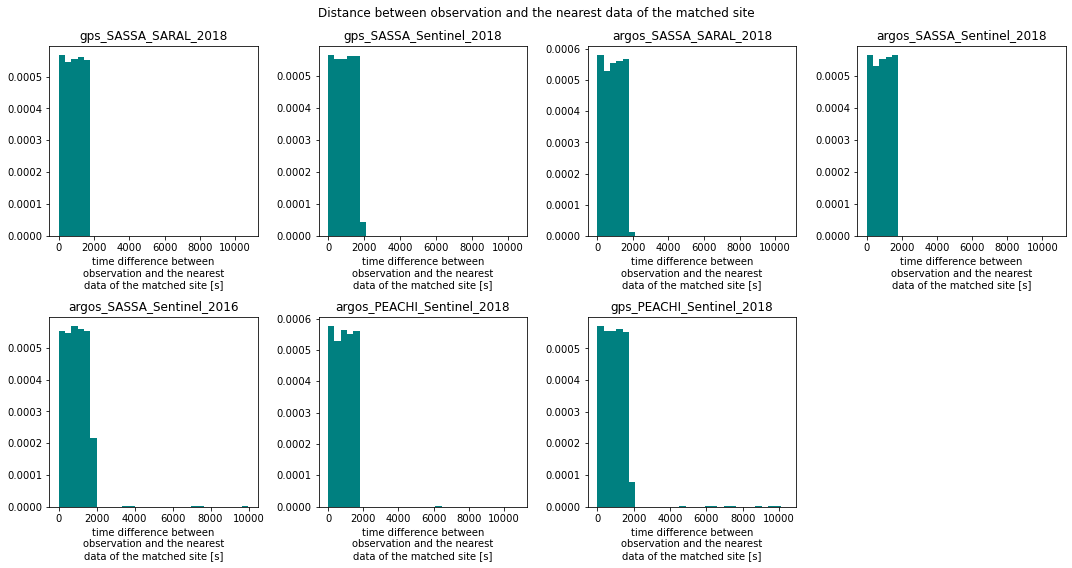

In [115]:
fig = plt.figure(figsize=(15,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    DS[key]["alti___time_difference"].plot.hist(bins=30, ax=ax,density=True, color='teal')
    ax.set_title(key)
    j+=1

fig.suptitle("Distance between observation and the nearest data of the matched site")
fig.tight_layout()

## GPS vs Argos

In [11]:
ds_repart_gps = ds_repart.sel(drifter_sat_year = [l for l in labels if 'gps' in l]).sum(dim='drifter_sat_year')
ds_repart_argos = ds_repart.sel(drifter_sat_year = [l for l in labels if 'argos' in l]).sum(dim='drifter_sat_year')
ds_repart_gps = ds_repart_gps.where(ds_repart_gps!=0, np.nan)
ds_repart_argos = ds_repart_argos.where(ds_repart_argos!=0, np.nan)
DS_={'(a) \n Colocalisations with GPS drifters' : ds_repart_gps, '(b) \n Colocalisations with Argos drifters' : ds_repart_argos}

In [25]:
ds_repart_gps

<xarray.DataArray 'histogram_lon_lat' (lon_bin: 72, lat_bin: 36)>
array([[ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0., nan, ..., nan, nan,  0.],
       [ 0.,  0., nan, ..., nan, nan,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.]])
Coordinates:
  * lon_bin  (lon_bin) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat_bin  (lat_bin) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5

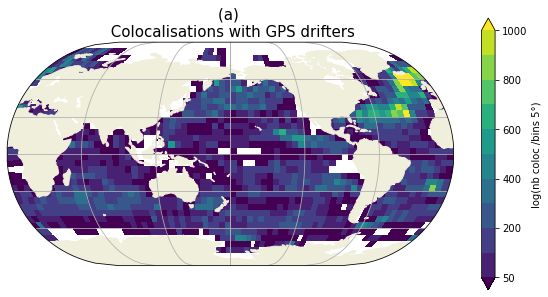

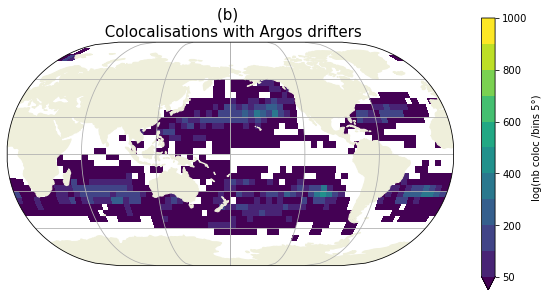

In [30]:
repart_list = []
for key in DS_:

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    DS_[key].rename('log(nb coloc /bins '+str(dl) +'°)').plot(x="lon_bin", y="lat_bin", ax=ax, vmax=2,transform=ccrs.PlateCarree(), levels=[50]+list(np.arange(100,1100, 100 )))
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    ax.set_title(key,fontsize=15)
    gl = ax.gridlines()


In [58]:
ds

<xarray.DataArray 'histogram_lon_lat' (drifter_type: 2, lon_bin: 72, lat_bin: 36)>
array([[[  0,   0,  98, ...,   0,   0,   0],
        [  0,   0,  62, ...,   0,   0,   0],
        [  0,   0,  86, ...,   0,   0,   0],
        ...,
        [  0,   0,  88, ...,  68,   1,   0],
        [  0,   0,  13, ...,   3,   3,   0],
        [  0,   0, 162, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]])
Coordinates:
  * lon_bin       (lon_bin) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * lat_bin       (lat_bin) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * drifter_type  (drifter_type) object '(a) \n Colocalisations with GPS drif...

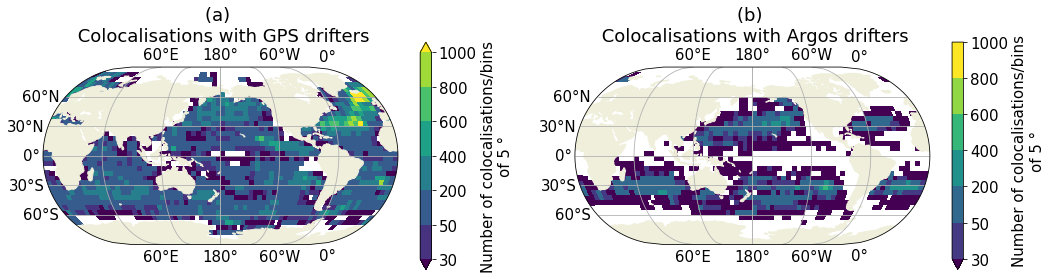

In [12]:
fig = plt.figure(figsize=(15,4))
plt.rcParams.update({'font.size':15})
ax = fig.add_subplot(1,2,1, projection=ccrs.EckertIII(central_longitude=-180))
ax.add_feature(cfeature.LAND, zorder=2)
ds_repart_gps.rename(f'Number of colocalisations/bins of {dl} °').plot(x="lon_bin", y="lat_bin", ax=ax, transform=ccrs.PlateCarree(),levels=[30, 50]+list(np.arange(200,1100, 200 )))
ax.set_title('(a) \n Colocalisations with GPS drifters')
gl = ax.gridlines(draw_labels=True,)

ax1 = fig.add_subplot(1,2,2, projection=ccrs.EckertIII(central_longitude=-180))
ax1.add_feature(cfeature.LAND, zorder=2)
ds_repart_argos.rename(f'Number of colocalisations/bins of {dl} °').plot(x="lon_bin", y="lat_bin", ax=ax1, transform=ccrs.PlateCarree(),levels=[30,50]+list(np.arange(200,1100, 200 )))
ax1.set_title('(b) \n Colocalisations with Argos drifters')
gl = ax1.gridlines(draw_labels=True,)

fig.tight_layout()

In [35]:
print(ds_repart_gps.mean().values, ds_repart_gps.max().values, ds_repart_gps.min().values,)

133.7447528774543 1908.0 1.0


In [37]:
print(ds_repart_argos.mean().values, ds_repart_argos.max().values, ds_repart_argos.min().values,)

44.36713286713287 409.0 1.0


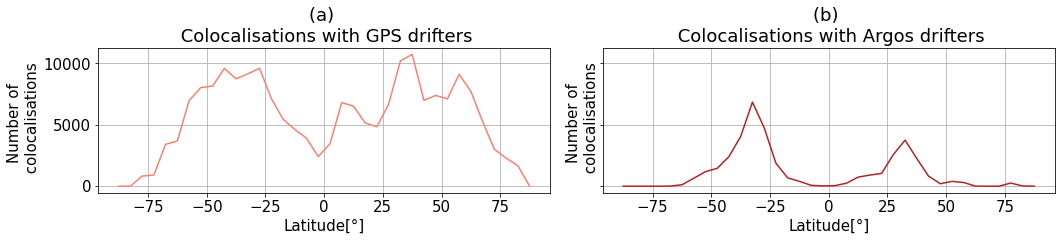

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,4), sharey=True)

ds_repart_gps.sum("lon_bin").plot(ax=ax[0], color='salmon')
ax[0].grid( zorder=0)
ax[0].set_title('(a) \n Colocalisations with GPS drifters')
ax[0].set_ylabel('Number of \n colocalisations')
ax[0].set_xlabel('Latitude[°]')
ds_repart_argos.sum("lon_bin").plot(ax=ax[1], color='firebrick')
ax[1].grid( zorder=0)
ax[1].set_title('(b) \n Colocalisations with Argos drifters')
ax[1].set_ylabel('Number of \n colocalisations')
ax[1].set_xlabel('Latitude[°]')
#fig.legend(ncol=4, fontsize=10,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

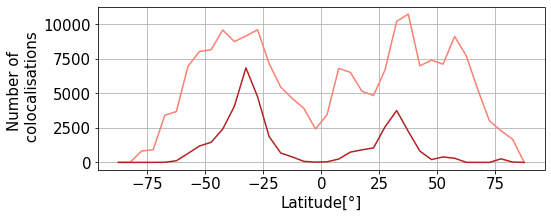

In [26]:
plt.figure(figsize=(8,3))
ds_repart_gps.sum("lon_bin").plot(label='Colocalisations with GPS drifters', color='salmon')
ds_repart_argos.sum("lon_bin").plot(label='Colocalisations with Argos drifters', color='firebrick')
plt.ylabel('Number of \n colocalisations')
plt.xlabel('Latitude[°]')
plt.grid()


In [40]:
ds_gps= xr.concat([DS[l][['alti___time_difference','alti___distance']] for l in labels if 'gps' in l], dim='obs')
ds_argos= xr.concat([DS[l][['alti___time_difference','alti___distance']] for l in labels if 'argos' in l], dim='obs')
ds_gps['alti___distance'] = (ds_gps.alti___distance/1000).assign_attrs({'units':'km', 'long_name':ds_gps.alti___distance.attrs['long_name']})
ds_gps['alti___time_difference'] = (ds_gps.alti___time_difference/3600).assign_attrs({'units':'h', 'long_name':ds_gps.alti___time_difference.attrs['long_name']})
ds_argos['alti___distance'] = (ds_argos.alti___distance/1000).assign_attrs({'units':'km', 'long_name':ds_argos.alti___distance.attrs['long_name']})
ds_argos['alti___time_difference'] = (ds_argos.alti___time_difference/3600).assign_attrs({'units':'h', 'long_name':ds_argos.alti___time_difference.attrs['long_name']})

In [41]:
ds_argos

<xarray.Dataset>
Dimensions:                 (obs: 38067)
Coordinates:
    lat                     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                    (obs) datetime64[ns] dask.array<chunksize=(11960,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables:
    alti___time_difference  (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___distance         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__argos
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

### time and distance to matchup

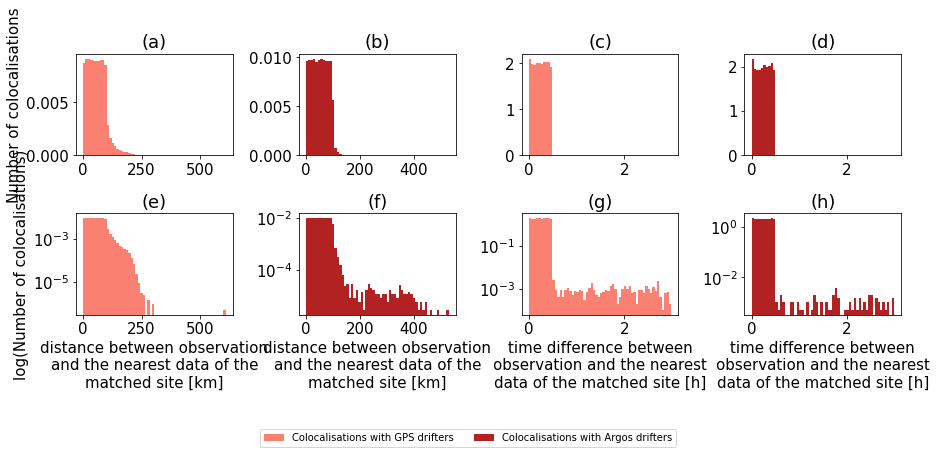

In [60]:
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(13,6),)
ax=ax.flatten()

ds_gps.alti___distance.plot.hist(bins=60, density=True,  color='salmon', label ='Colocalisations with GPS drifters', ax=ax[0])
ax[0].set_title('(a)')
ax[0].set_ylabel('Number of colocalisations')

ds_argos.alti___distance.plot.hist(bins=60, density=True,   color='firebrick', label ='Colocalisations with Argos drifters',ax=ax[1] )
ax[1].set_title('(b)')

ds_gps.alti___time_difference.plot.hist(bins=60, density=True,  ax=ax[2],color='salmon', )
ax[2].set_title('(c)')

ds_argos.alti___time_difference.plot.hist(bins=60, density=True,   ax=ax[3] , color='firebrick')
ax[3].set_title('(d)')

ds_gps.alti___distance.plot.hist(bins=60, density=True,   color='salmon', ax=ax[4])
ax[4].set_title('(e)')
ax[4].set_ylabel('log(Number of colocalisations)')

ds_argos.alti___distance.plot.hist(bins=60, density=True,   color='firebrick',ax=ax[5] )
ax[5].set_title('(f)')

ds_gps.alti___time_difference.plot.hist(bins=60, density=True,  ax=ax[6],color='salmon', )
ax[6].set_title('(g)')

ds_argos.alti___time_difference.plot.hist(bins=60, density=True,  ax=ax[7] , color='firebrick')
ax[7].set_title('(h)')

for a in ax[:4] : 
    a.set_xlabel('')
for a in ax[4:] : 
    a.set_yscale('log')
fig.legend(ncol=2, fontsize=10,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [43]:
ds_

NameError: name 'ds_' is not defined

In [ ]:
plt.plot(ds_gps.alti___time_difference.values, ds_gps.alti___distance.values, ls='', marker='.')

In [67]:
def scatter_hist(ds,x, y, axi, ax_histx, ax_histy, color='salmon', bins=60, x_label=1, y_label=1, **kwargs,):
    # no labels
    ax.grid(zorder=0)
    ax_histx.grid(axis='x', zorder=0)
    ax_histy.grid(axis='y', zorder=0)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ds.plot.scatter(x, y, color=color, ax=axi, zorder=1, marker='+')
    
    ds[x].plot.hist(bins=bins, density=True,  color=color, ax=ax_histx, zorder=1)
    ds[y].plot.hist(bins=bins, density=True,  color=color, ax=ax_histy, orientation='horizontal', zorder=1)
    ax_histx.set_xlabel('')
    ax_histy.set_xlabel('')

    ax_histx.set_title(**kwargs)
    if isinstance(x_label, str): 
        ax.set_xlabel(x_label)
        ax_histx.set_ylabel('hist('+x_label+')\n')
    if isinstance(y_label, str): 
        ax.set_ylabel(y_label)
        ax_histy.set_xlabel('hist('+y_label+')\n')

    #ax_histx.set_yscale('log')
    #ax_histy.set_xscale('log')

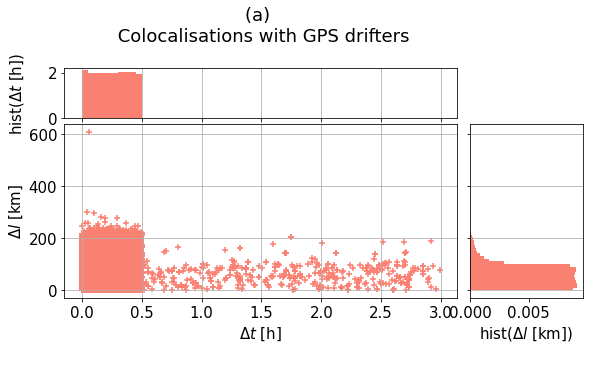

In [75]:
# start with a square Figure
fig = plt.figure(figsize=(9, 4))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(ds_gps, 'alti___time_difference', 'alti___distance', ax, ax_histx, ax_histy,label ='(a) \n Colocalisations with GPS drifters\n', y_label=r'$\Delta l$ [km]',x_label=r'$\Delta t$ [h]')
#fig.suptitle('(a) \n Colocalisations with GPS drifters\n', fontsize=15)
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
plt.show()

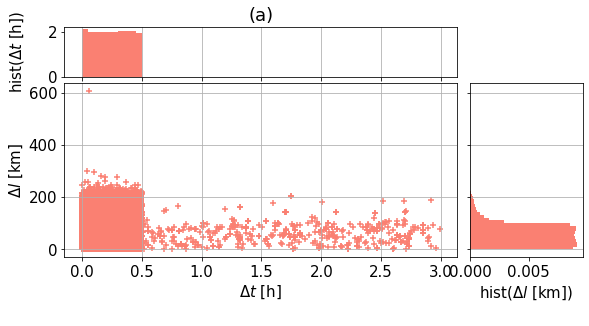

In [72]:
# start with a square Figure
fig = plt.figure(figsize=(9, 4))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(ds_gps, 'alti___time_difference', 'alti___distance', ax, ax_histx, ax_histy,label ='(a)', y_label=r'$\Delta l$ [km]',x_label=r'$\Delta t$ [h]')
#fig.suptitle('(a) \n Colocalisations with GPS drifters\n', fontsize=15)
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
plt.show()

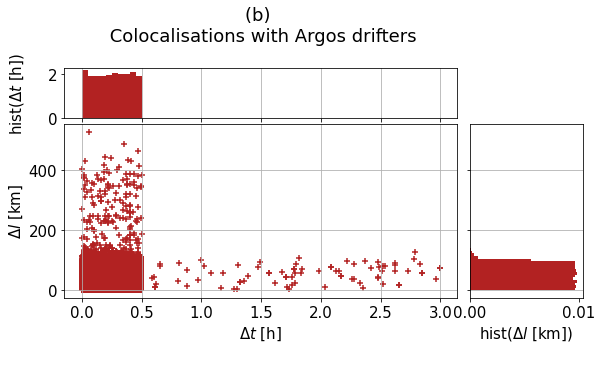

In [73]:
# start with a square Figure
fig = plt.figure(figsize=(9, 4))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(ds_argos, 'alti___time_difference', 'alti___distance', ax, ax_histx, ax_histy,color = 'firebrick',label ='(b) \n Colocalisations with Argos drifters\n', y_label=r'$\Delta l$ [km]',x_label=r'$\Delta t$ [h]')
#fig.suptitle('(a) \n Colocalisations with GPS drifters\n', fontsize=15)
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
plt.show()

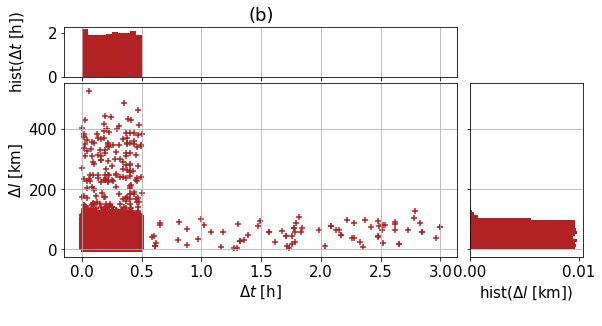

In [74]:
# start with a square Figure
fig = plt.figure(figsize=(9, 4))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(ds_argos, 'alti___time_difference', 'alti___distance', ax, ax_histx, ax_histy,color = 'firebrick',label ='(b)', y_label=r'$\Delta l$ [km]',x_label=r'$\Delta t$ [h]')
#fig.suptitle('(a) \n Colocalisations with GPS drifters\n', fontsize=15)
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
plt.show()

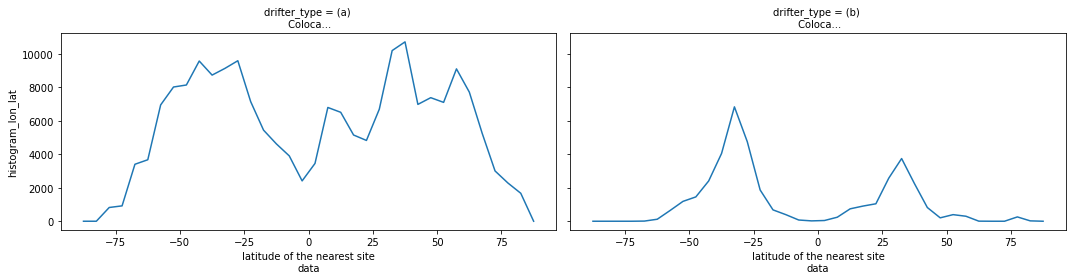

In [172]:
fg = ds.sum("lon_bin").plot(col='drifter_type', col_wrap=2, figsize=(15,4))
fg.fig.tight_layout()

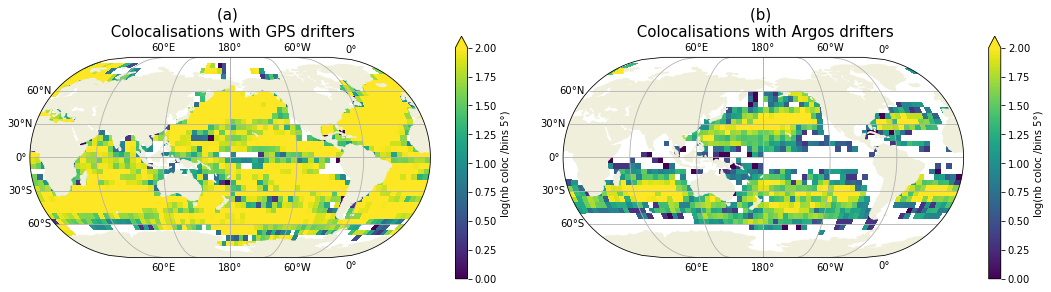

In [46]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,2,1, projection=ccrs.EckertIII(central_longitude=-180))
ax.add_feature(cfeature.LAND, zorder=2)
np.log10(ds_repart_gps.rename('log(nb coloc /bins '+str(dl) +'°)')).plot(x="lon_bin", y="lat_bin", ax=ax, vmax=2,transform=ccrs.PlateCarree())
ax.set_title('(a) \n Colocalisations with GPS drifters', fontsize=15)
gl = ax.gridlines(draw_labels=True,)

ax1 = fig.add_subplot(1,2,2, projection=ccrs.EckertIII(central_longitude=-180))
ax1.add_feature(cfeature.LAND, zorder=2)
np.log10(ds_repart_argos.rename('log(nb coloc /bins '+str(dl) +'°)')).plot(x="lon_bin", y="lat_bin", ax=ax1, vmax=2,transform=ccrs.PlateCarree())
ax1.set_title('(b) \n Colocalisations with Argos drifters', fontsize=15)
gl = ax1.gridlines(draw_labels=True,)

fig.tight_layout()

## Angle

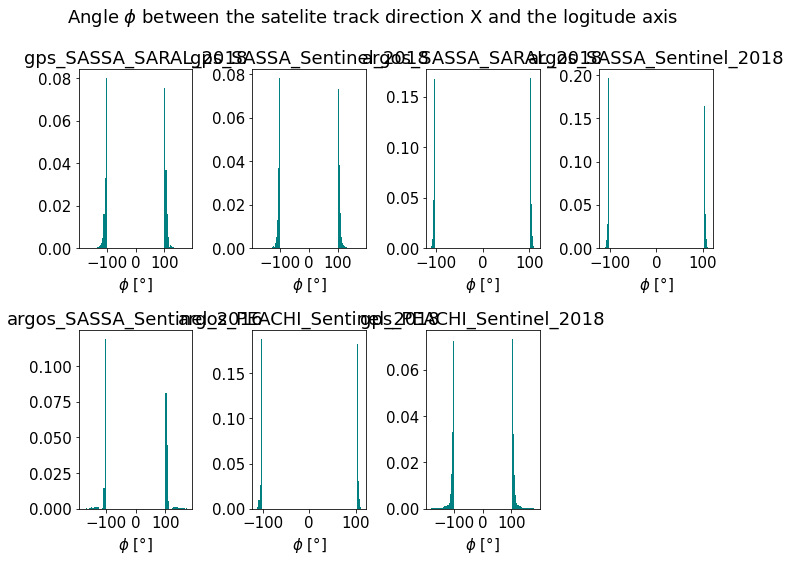

In [76]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    DS[key]["box_phi"].plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$\phi$ [°]')
    ax.set_title(key)
    j+=1

fig.suptitle(r"Angle $\phi$ between the satelite track direction X and the logitude axis")
fig.tight_layout()

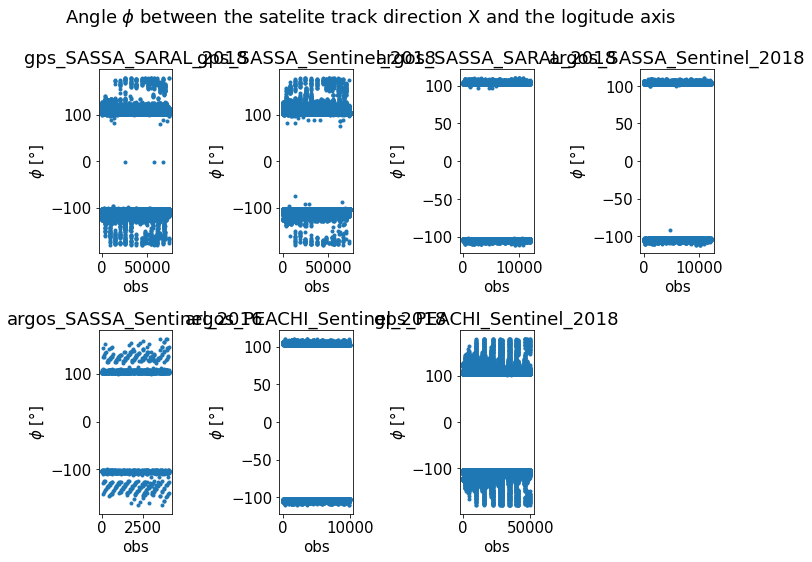

In [77]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    DS[key]["box_phi"].plot(ls='', marker='.')
    ax.set_ylabel(r'$\phi$ [°]')
    ax.set_title(key)
    j+=1

fig.suptitle(r"Angle $\phi$ between the satelite track direction X and the logitude axis")
fig.tight_layout()

fig = plt.figure(figsize=(15,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,8,j+1)
    sin_phi = np.sin(DS[key]["box_phi"]*np.pi/180)
    sin_phi.plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$sin(\phi)$ []')
    ax.set_xlim(-1, -0.9)
    ax.set_title(key)
    ax = fig.add_subplot(2,8,j+2)
    sin_phi = np.sin(DS[key]["box_phi"]*np.pi/180)
    sin_phi.plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$sin(\phi)$ []')
    ax.set_xlim(0.9, 1)
    j+=2

fig.suptitle(r"$sin(\phi)$")
fig.tight_layout()

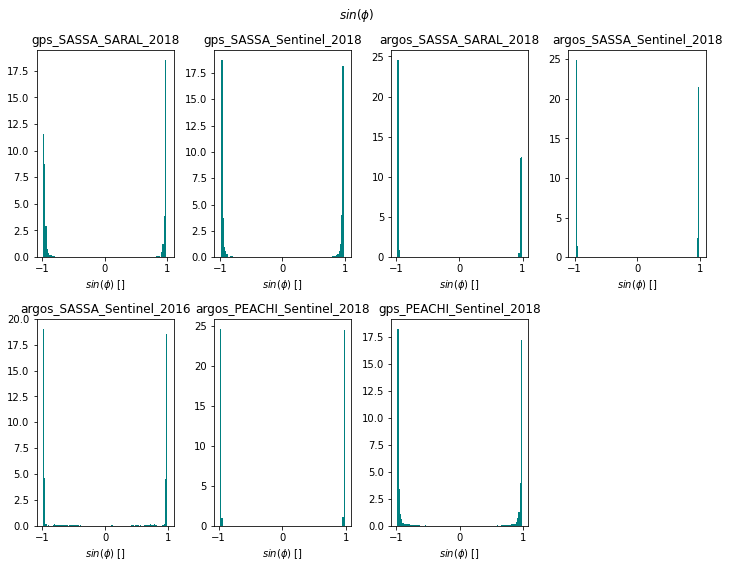

In [97]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    sin_phi = np.sin(DS[key]["box_phi"]*np.pi/180)
    sin_phi.plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$sin(\phi)$ []')
    ax.set_title(key)
    j+=1

fig.suptitle(r"$sin(\phi)$")
fig.tight_layout()

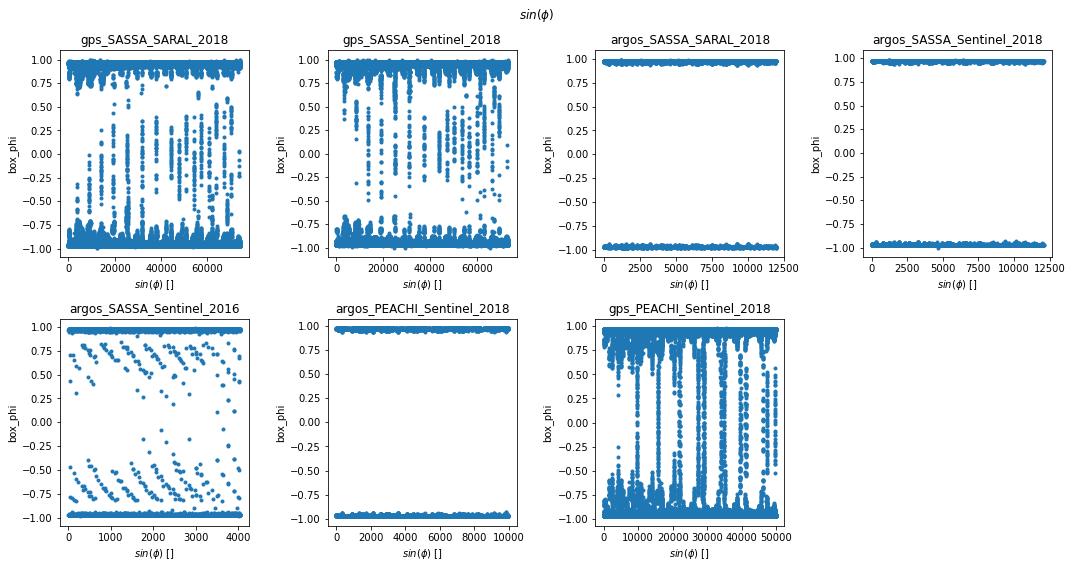

In [61]:
fig = plt.figure(figsize=(15,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    sin_phi = np.sin(DS[key]["box_phi"]*np.pi/180)
    sin_phi.plot(ls='', marker='.')
    ax.set_xlabel(r'$sin(\phi)$ []')
    ax.set_title(key)
    j+=1

fig.suptitle(r"$sin(\phi)$")
fig.tight_layout()

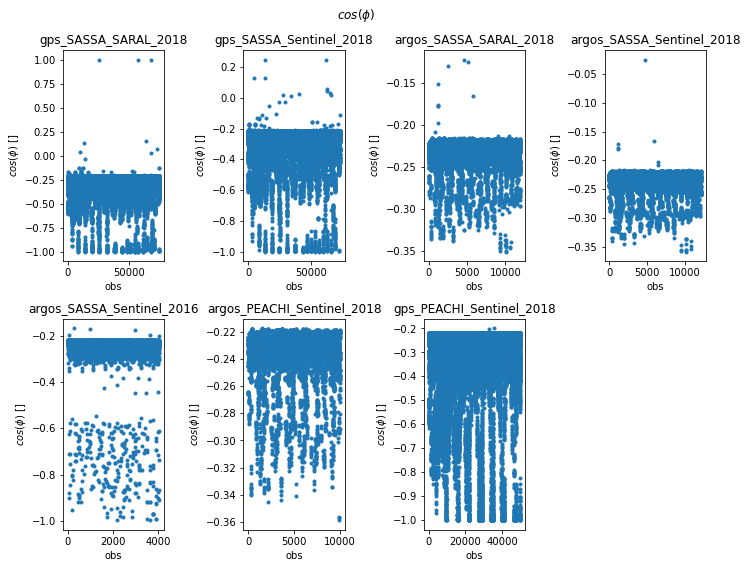

In [101]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    cos_phi = np.cos(DS[key]["box_phi"]*np.pi/180)
    cos_phi.plot(ls='', marker='.')
    ax.set_ylabel(r'$cos(\phi)$ []')
    ax.set_title(key)
    j+=1

fig.suptitle(r"$cos(\phi)$")
fig.tight_layout()

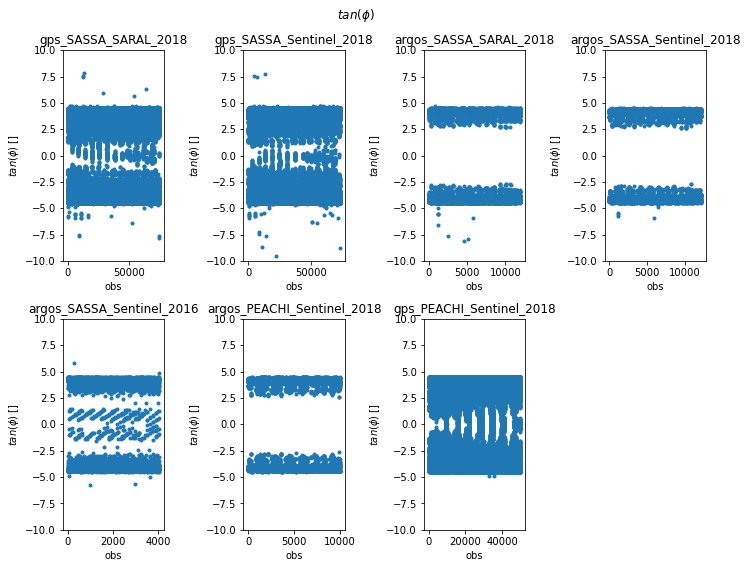

In [100]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    tan_phi = np.tan(DS[key]["box_phi"]*np.pi/180)
    tan_phi.plot(ls='', marker='.')
    ax.set_ylabel(r'$tan(\phi)$ []')
    ax.set_title(key)
    ax.set_ylim(-10,10)
    j+=1

fig.suptitle(r"$tan(\phi)$")
fig.tight_layout()

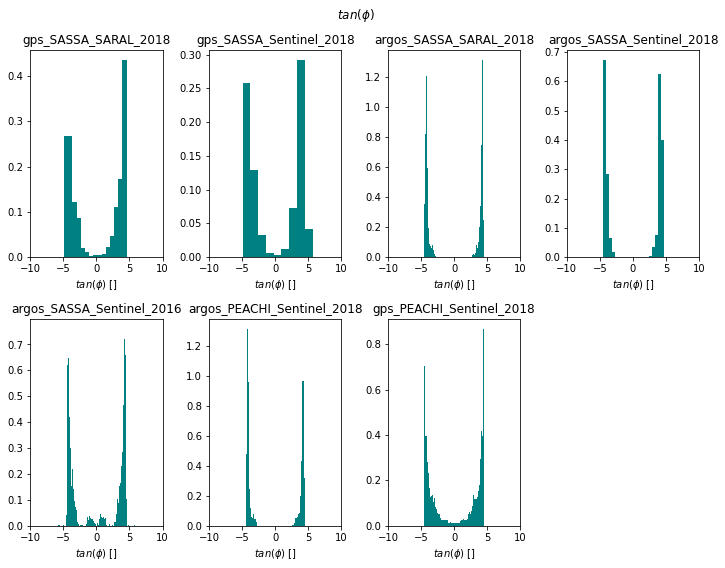

In [104]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS:
    ax = fig.add_subplot(2,4,j+1)
    tan_phi = np.tan(DS[key]["box_phi"]*np.pi/180)
    tan_phi.plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$tan(\phi)$ []')
    ax.set_title(key)
    ax.set_xlim(-10,10)
    j+=1

fig.suptitle(r"$tan(\phi)$")
fig.tight_layout()

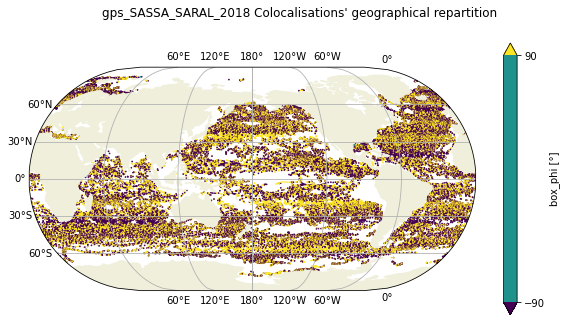

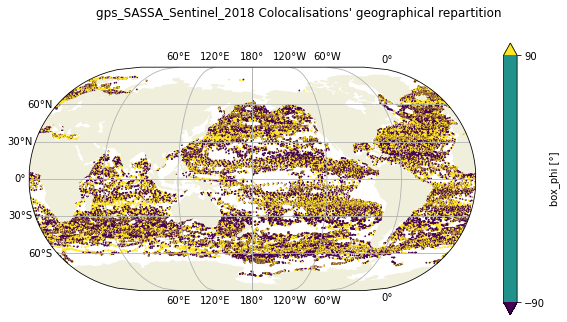

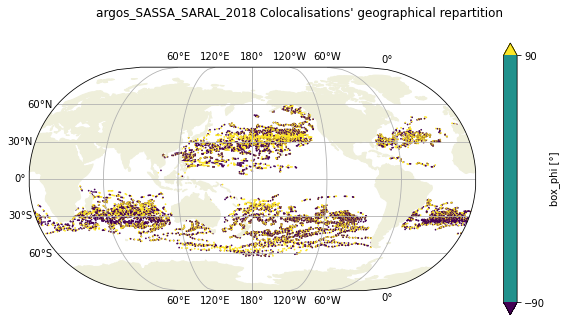

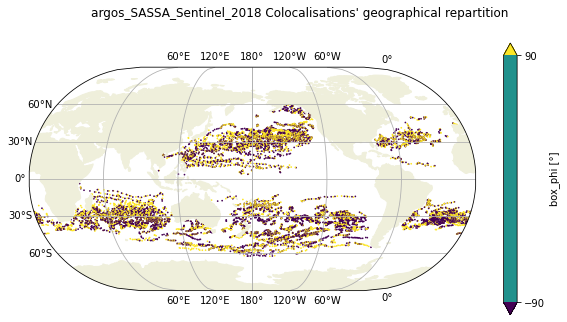

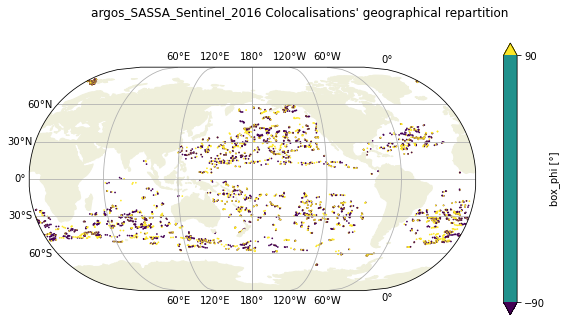

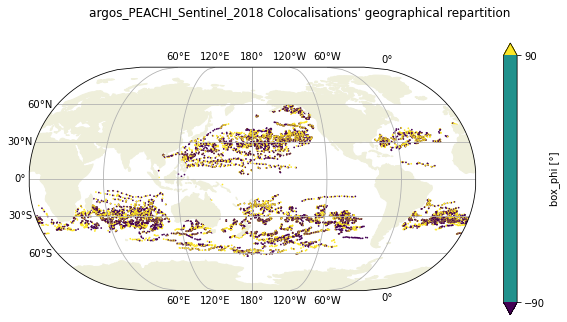

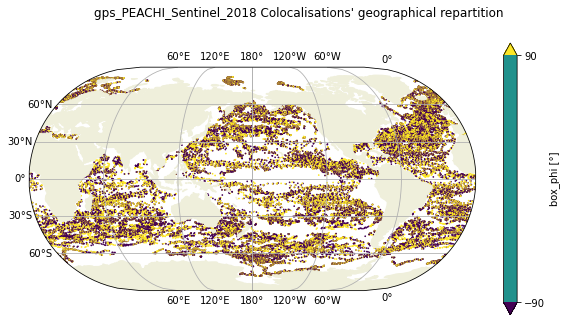

In [109]:
for key in DS:

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    gl = ax.gridlines(draw_labels=True,)
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    DS[key].plot.scatter( x="lon", y="lat", hue='box_phi',cmap='viridis',s=0.5, ax=ax,transform=ccrs.PlateCarree(), levels=2, vmax=90, vmin=-90)
    
    #ax.set_title(key,fontsize=15)

    fig.suptitle(f"{key} Colocalisations' geographical repartition")

# SELECT $sin\phi>>cos\phi$

## criteria $sin\phi>3.5cos\phi$ ?

In [91]:
alpha =4
DS_sel = {}
for key in DS : 
    DS[key]['abs_tan_phi']= abs(np.tan(DS[key]["box_phi"]*np.pi/180))
    DS_sel[key]=DS[key].where(DS[key].abs_tan_phi>alpha, drop=True)
    print(f"{DS_sel[key].sizes['obs']}/{DS[key].sizes['obs']}")

38411/74235
36621/73334
9370/11960
9162/12077
2454/4054
7659/9976
23676/49972


In [92]:
dl = 5
lon, lat = np.arange(-180, 180+dl, dl), np.arange(-90,90+dl,dl)
bins_lonlat =[lon,lat]

repart_list = []
for key in DS_sel:
    repartition = diag.coloc_repartition(DS_sel[key], bins=bins_lonlat)
    repart_list.append(repartition)
ds_repart_sel = xr.concat(repart_list, dim = pd.Index(name='drifter_sat_year', data=labels))

In [93]:
ds_repart_gps_sel = ds_repart_sel.sel(drifter_sat_year = [l for l in labels if 'gps' in l]).sum(dim='drifter_sat_year')
ds_repart_gps_sel = ds_repart_gps_sel.where(ds_repart_gps_sel!=0, np.nan)

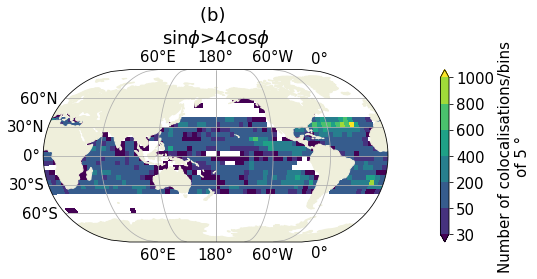

In [95]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
ax.add_feature(cfeature.LAND, zorder=2)
ds_repart_gps_sel.rename(f'Number of colocalisations/bins of {dl} °').plot(x="lon_bin", y="lat_bin", ax=ax, transform=ccrs.PlateCarree(),levels=[30, 50]+list(np.arange(200,1100, 200 )))
ax.set_title('(b) \n'+fr'sin$\phi$>{alpha}cos$\phi$')
gl = ax.gridlines(draw_labels=True,)

fig.tight_layout()

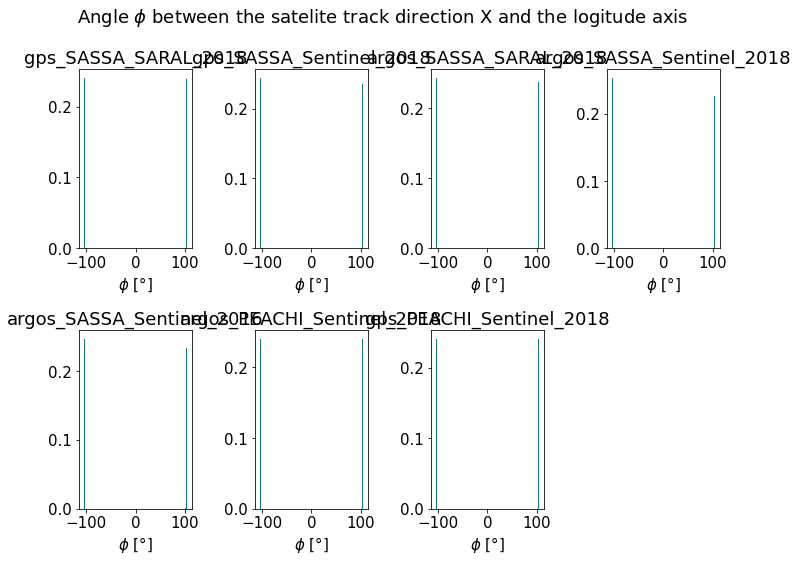

In [82]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS_sel:
    ax = fig.add_subplot(2,4,j+1)
    DS_sel[key]["box_phi"].plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$\phi$ [°]')
    ax.set_title(key)
    j+=1

fig.suptitle(r"Angle $\phi$ between the satelite track direction X and the logitude axis")
fig.tight_layout()

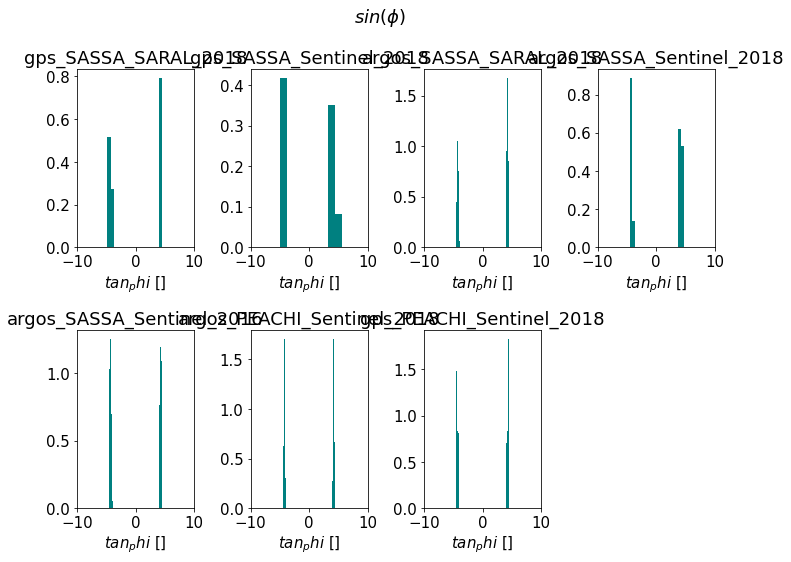

In [83]:
fig = plt.figure(figsize=(10,8))
j=0
for key in DS_sel:
    ax = fig.add_subplot(2,4,j+1)
    tan_phi = np.tan(DS_sel[key]["box_phi"]*np.pi/180)
    tan_phi.plot.hist(bins=100, ax=ax,density=True, color='teal')
    ax.set_xlabel(r'$tan_phi$ []')
    ax.set_title(key)
    ax.set_xlim(-10,10)
    j+=1

fig.suptitle(r"$sin(\phi)$")
fig.tight_layout()

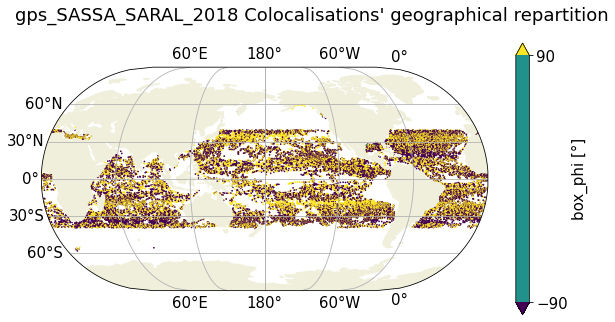

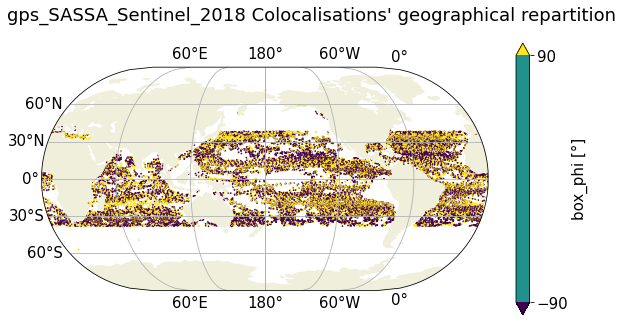

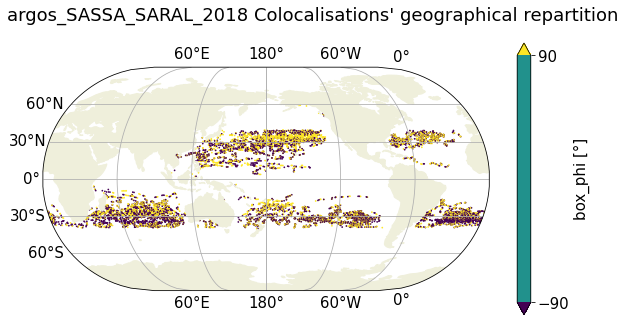

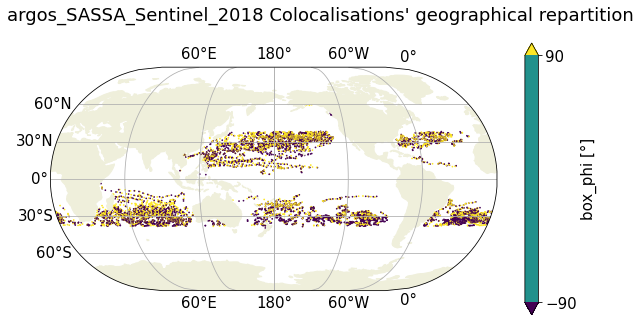

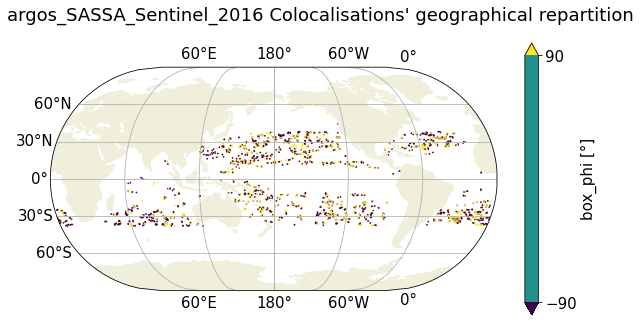

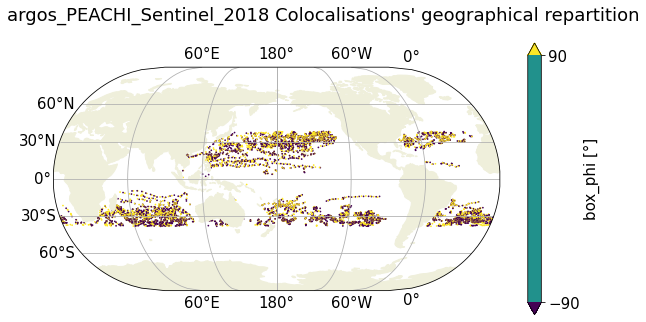

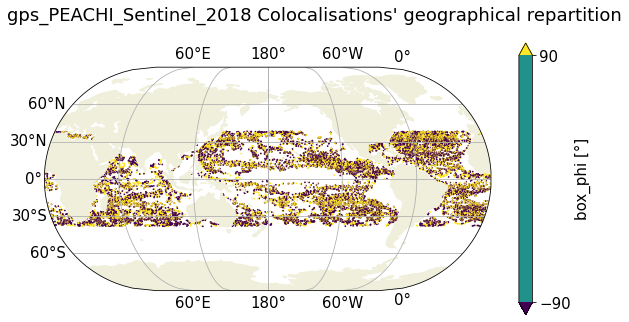

In [84]:
for key in DS_sel:

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    gl = ax.gridlines(draw_labels=True,)
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    DS_sel[key].plot.scatter( x="lon", y="lat", hue='box_phi',cmap='viridis',s=0.5, ax=ax,transform=ccrs.PlateCarree(), levels=2, vmax=90, vmin=-90)
    
    #ax.set_title(key,fontsize=15)

    fig.suptitle(f"{key} Colocalisations' geographical repartition")

In [96]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
